# FinMarks — Exploratory Data Analysis & Data Visualization (EDA)
This notebook loads **`merged_cleaned_dataset.csv`** and produces:
- Histograms, line chart, bar charts, scatter plots
- Correlation heatmap (numeric)
- Association matrix (categoricals, Cramér’s V)
- Inferential tests (Pearson/Spearman, t-test, ANOVA, Chi-square)
- Age binning + IQR outlier flagging/removal + *pre vs post* plots

Outputs are saved to `eda_outputs/`.

In [1]:
# --- Setup & Load
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from scipy import stats
import scipy.stats as ss
from statsmodels.tsa.stattools import adfuller

import warnings
from scipy.stats import ConstantInputWarning
# Silence scipy’s ConstantInputWarning when a column has no variance
warnings.filterwarnings("ignore", category=ConstantInputWarning)

plt.rcParams["figure.dpi"] = 110
sns.set(style="whitegrid", palette="muted", font_scale=1.05)

DATA_PATH = Path("merged_cleaned_dataset.csv")
OUT_DIR = Path("eda_outputs"); OUT_DIR.mkdir(exist_ok=True)

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.lower()

if "signupdate" in df.columns:
    df["signupdate"] = pd.to_datetime(df["signupdate"], errors="coerce")

for c in ["age","total_spent","avg_spent","num_transactions","max_transaction","min_transaction","engagement_score"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
print("Loaded:", df.shape)


Loaded: (1192, 12)


## Part A — Core Visuals & Base Tests (Code 1)


In [2]:
def save_show(fig, name):
    p = OUT_DIR / f"{name}.png"
    fig.savefig(p, bbox_inches="tight"); plt.show()
    print(f"Saved: {p}")


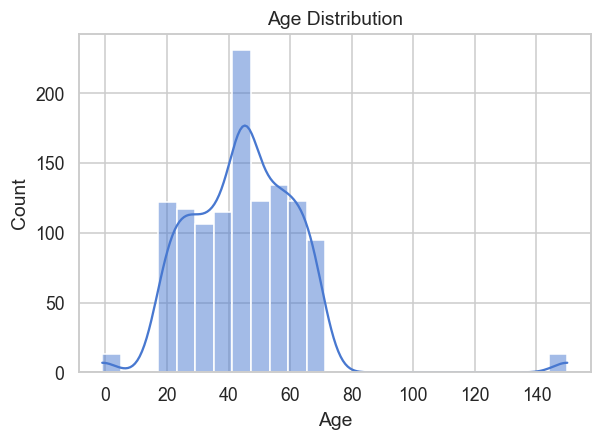

Saved: eda_outputs/hist_age.png


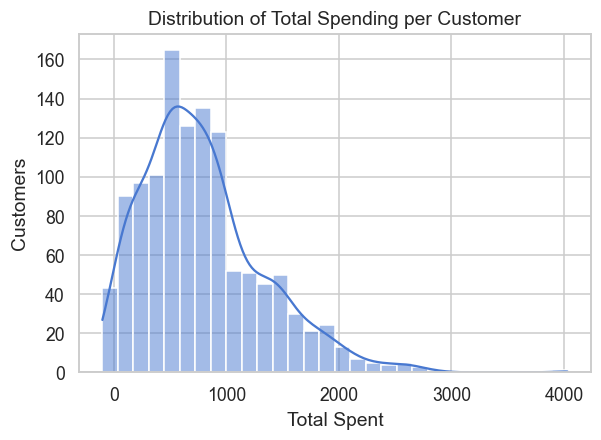

Saved: eda_outputs/hist_total_spent.png


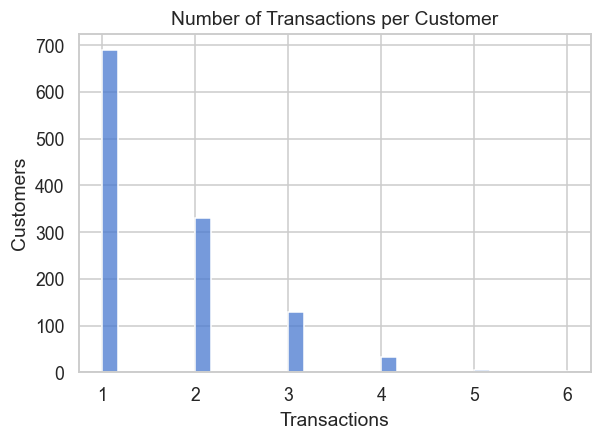

Saved: eda_outputs/hist_num_transactions.png


In [3]:
# Histograms
if "age" in df.columns:
    fig = plt.figure(figsize=(6,4)); sns.histplot(df["age"].dropna(), bins=25, kde=True)
    plt.title("Age Distribution"); plt.xlabel("Age"); plt.ylabel("Count")
    save_show(fig, "hist_age")

if "total_spent" in df.columns:
    fig = plt.figure(figsize=(6,4)); sns.histplot(df["total_spent"].dropna(), bins=30, kde=True)
    plt.title("Distribution of Total Spending per Customer"); plt.xlabel("Total Spent"); plt.ylabel("Customers")
    save_show(fig, "hist_total_spent")

if "num_transactions" in df.columns:
    fig = plt.figure(figsize=(6,4)); sns.histplot(df["num_transactions"].dropna(), bins=30, kde=False)
    plt.title("Number of Transactions per Customer"); plt.xlabel("Transactions"); plt.ylabel("Customers")
    save_show(fig, "hist_num_transactions")


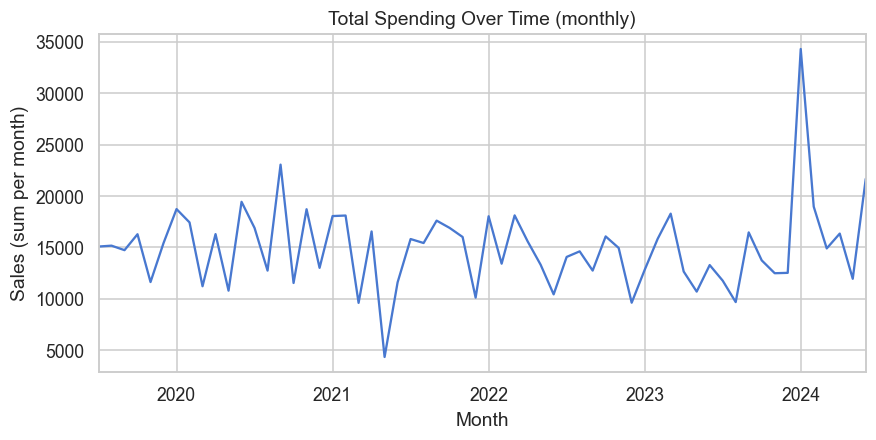

Saved: eda_outputs/line_total_spent_over_time.png


In [4]:
# Line chart (monthly)
if "signupdate" in df.columns and "total_spent" in df.columns:
    ts = (df.dropna(subset=["signupdate","total_spent"])
            .set_index("signupdate")["total_spent"]
            .resample("MS").sum())
    fig = plt.figure(figsize=(9,4)); ts.plot()
    plt.title("Total Spending Over Time (monthly)"); plt.xlabel("Month"); plt.ylabel("Sales (sum per month)")
    save_show(fig, "line_total_spent_over_time")


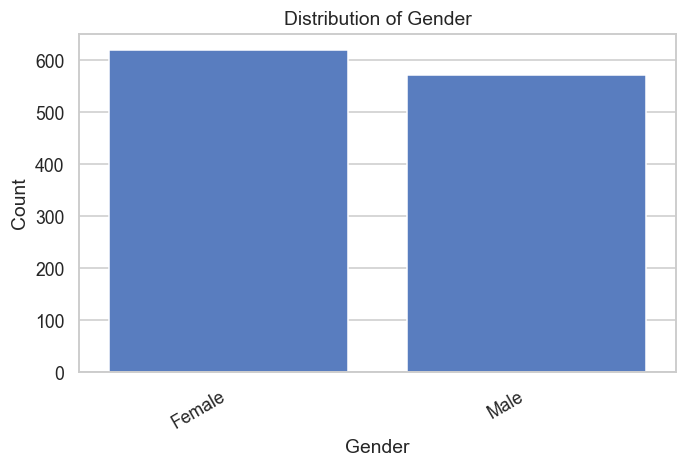

Saved: eda_outputs/bar_gender_top2.png


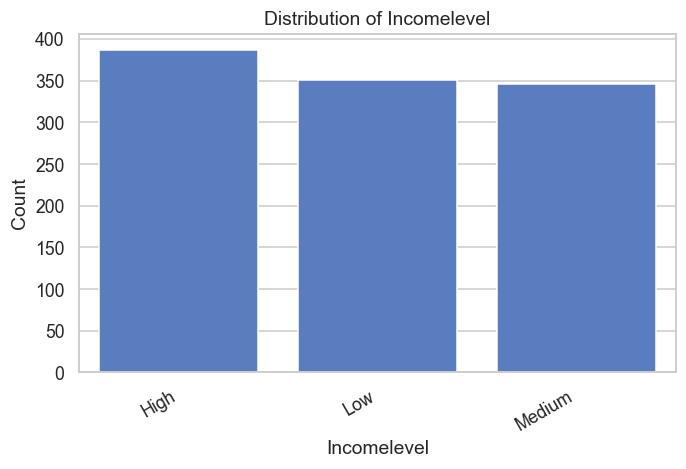

Saved: eda_outputs/bar_incomelevel_top3.png


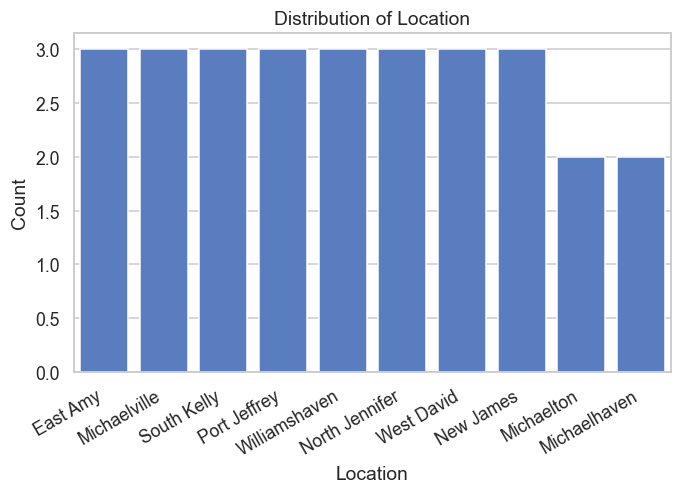

Saved: eda_outputs/bar_location_top10.png


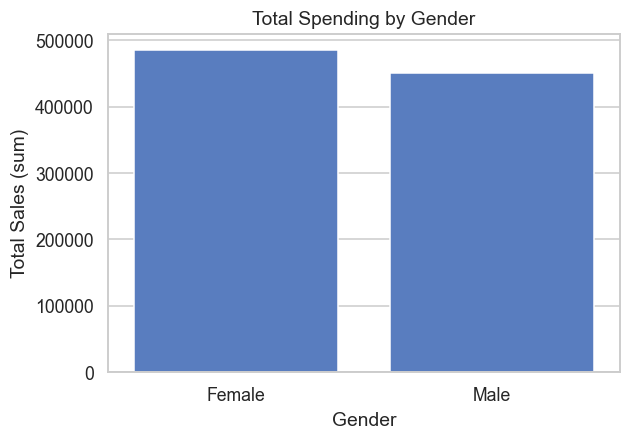

Saved: eda_outputs/bar_total_spent_by_gender.png


In [5]:
# Bar charts
def top_bar(col, topn=10, title=None):
    vc = df[col].astype("category").value_counts().head(topn)
    fig = plt.figure(figsize=(7,4)); sns.barplot(x=vc.index.astype(str), y=vc.values)
    plt.title(title or f"Top {topn} {col.title()}"); plt.xlabel(col.title()); plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right"); save_show(fig, f"bar_{col}_top{topn}")

for cat in ["gender","incomelevel","location"]:
    if cat in df.columns:
        top_bar(cat, topn=10 if cat=="location" else df[cat].nunique(), title=f"Distribution of {cat.title()}")

if "gender" in df.columns and "total_spent" in df.columns:
    fig = plt.figure(figsize=(6,4))
    sns.barplot(data=df, x="gender", y="total_spent", estimator=sum, errorbar=None)
    plt.title("Total Spending by Gender"); plt.xlabel("Gender"); plt.ylabel("Total Sales (sum)")
    save_show(fig, "bar_total_spent_by_gender")


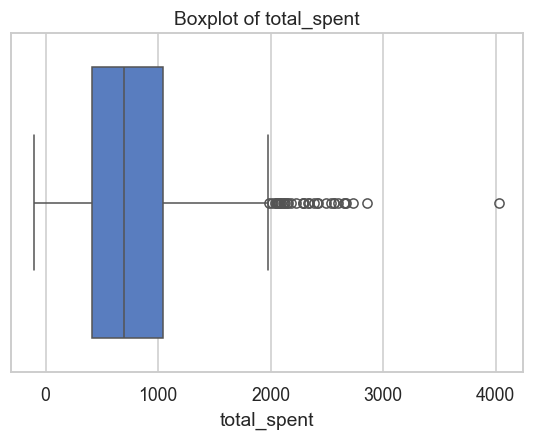

Saved: eda_outputs/box_total_spent.png


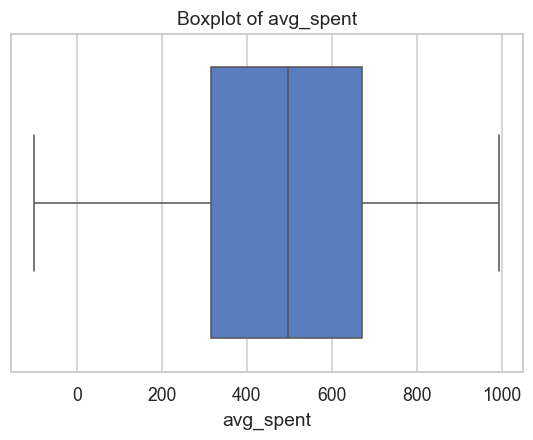

Saved: eda_outputs/box_avg_spent.png


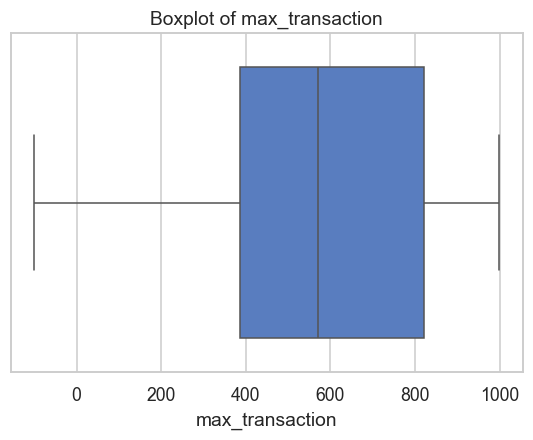

Saved: eda_outputs/box_max_transaction.png


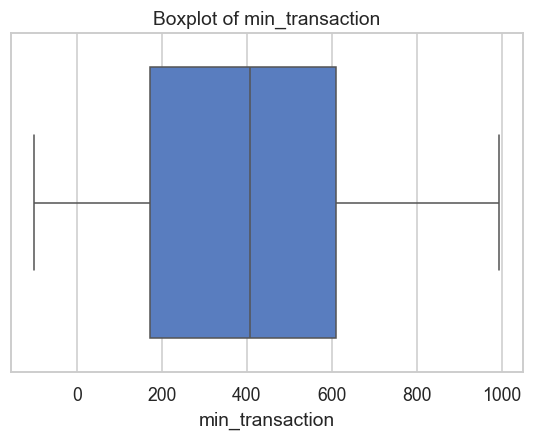

Saved: eda_outputs/box_min_transaction.png


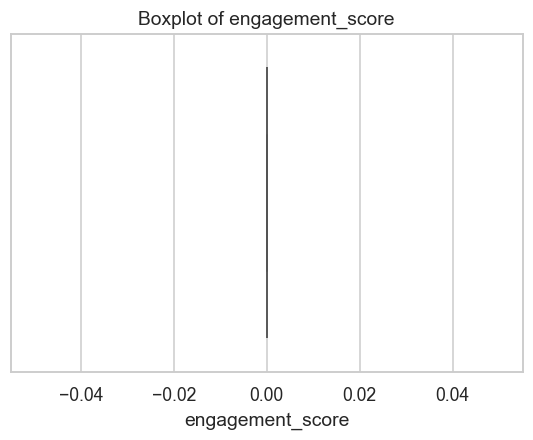

Saved: eda_outputs/box_engagement_score.png


In [6]:
# Box plots
for col in ["total_spent","avg_spent","max_transaction","min_transaction","engagement_score"]:
    if col in df.columns:
        fig = plt.figure(figsize=(6,4)); sns.boxplot(x=df[col].dropna())
        plt.title(f"Boxplot of {col}"); save_show(fig, f"box_{col}")


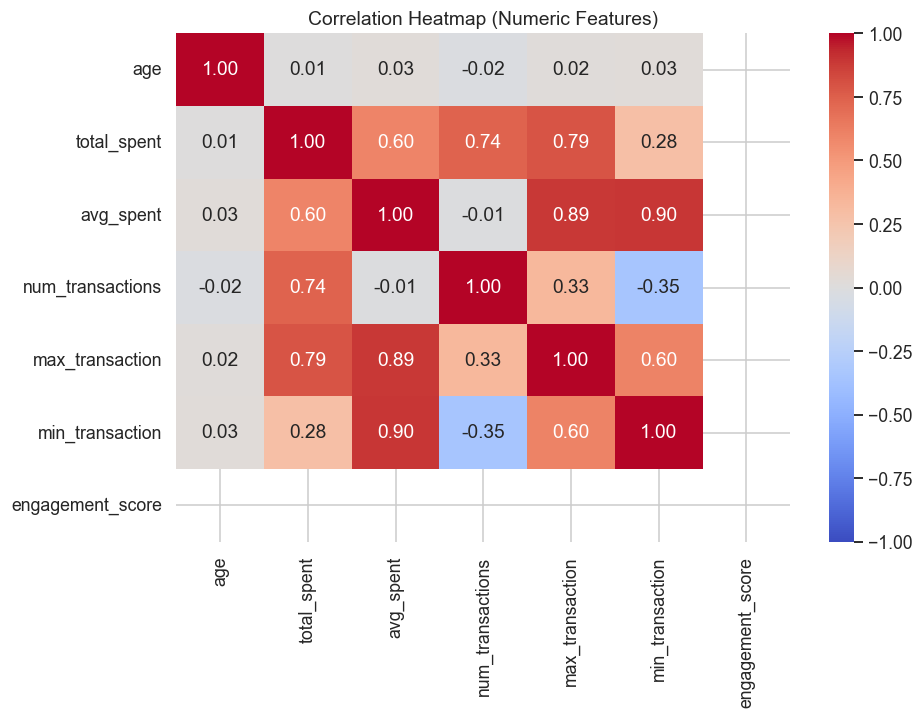

Saved: eda_outputs/heatmap_correlation_numeric.png


In [7]:
# Correlation heatmap
num_df = df.select_dtypes(include=["number"]).copy()
if not num_df.empty:
    corr = num_df.corr(numeric_only=True)
    fig = plt.figure(figsize=(9,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
    plt.title("Correlation Heatmap (Numeric Features)")
    save_show(fig, "heatmap_correlation_numeric")
    corr.to_csv(OUT_DIR / "correlation_matrix_numeric.csv", index=True)


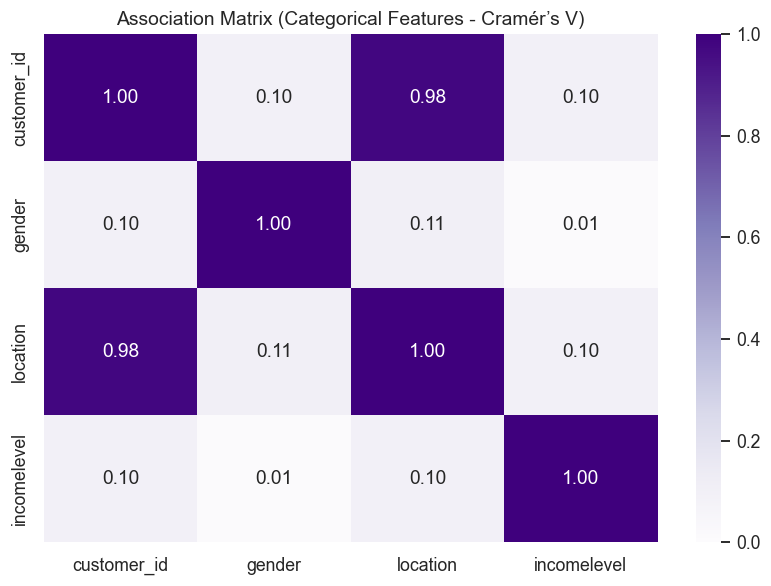

Saved: eda_outputs/heatmap_association_categoricals.png


In [8]:
# Association matrix (Cramér's V)
def cramers_v(x, y):
    tbl = pd.crosstab(x, y); chi2 = ss.chi2_contingency(tbl)[0]; n = tbl.sum().sum()
    phi2 = chi2 / max(n, 1); r, k = tbl.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) if n > 1 else 0
    rcorr = r - ((r-1)**2)/(n-1) if n > 1 else r
    kcorr = k - ((k-1)**2)/(n-1) if n > 1 else k
    denom = min((kcorr-1), (rcorr-1)); 
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

cat_df = df.select_dtypes(include=["object","category"]).copy()
if not cat_df.empty:
    cat_cols = [c for c in cat_df.columns if cat_df[c].nunique() > 1]
    assoc = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))), index=cat_cols, columns=cat_cols, dtype=float)
    for i, c1 in enumerate(cat_cols):
        for j, c2 in enumerate(cat_cols):
            if i <= j:
                v = 1.0 if c1 == c2 else cramers_v(cat_df[c1], cat_df[c2])
                assoc.loc[c1, c2] = assoc.loc[c2, c1] = v
    fig = plt.figure(figsize=(9,6))
    sns.heatmap(assoc, annot=True, cmap="Purples", vmin=0, vmax=1, fmt=".2f")
    plt.title("Association Matrix (Categorical Features - Cramér’s V)")
    save_show(fig, "heatmap_association_categoricals")
    assoc.to_csv(OUT_DIR / "association_matrix_categoricals.csv", index=True)


In [9]:
# Inferential tests (base)
results_lines = []
pairs = [("age","total_spent"), ("num_transactions","total_spent"), ("avg_spent","total_spent")]
for a,b in pairs:
    if a in df.columns and b in df.columns:
        x = pd.to_numeric(df[a], errors="coerce"); y = pd.to_numeric(df[b], errors="coerce")
        ok = x.notna() & y.notna()
        if ok.sum() > 2:
            r,p = stats.pearsonr(x[ok], y[ok]); rs,ps = stats.spearmanr(x[ok], y[ok])
            results_lines += [f"Pearson {a} vs {b}: r={r:.3f}, p={p:.4g}", f"Spearman {a} vs {b}: ρ={rs:.3f}, p={ps:.4g}"]

def anova_on(target, factor):
    groups, labels = [], []
    if target in df.columns and factor in df.columns:
        for k,g in df[[target,factor]].dropna().groupby(factor):
            if len(g[target]) > 1: groups.append(g[target].values); labels.append(str(k))
    if len(groups) >= 2:
        F, p = stats.f_oneway(*groups); results_lines.append(f"ANOVA {target} ~ {factor}: F={F:.4f}, p={p:.4g} | groups={labels}")

for factor in ["gender","incomelevel"]:
    anova_on("total_spent", factor)

if "gender" in df.columns and "total_spent" in df.columns:
    g = df.dropna(subset=["gender","total_spent"]); cats = g["gender"].value_counts().index.tolist()
    if len(cats) == 2:
        a = g.loc[g["gender"]==cats[0], "total_spent"]; b = g.loc[g["gender"]==cats[1], "total_spent"]
        t, p = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
        results_lines.append(f"T-test total_spent by gender ({cats[0]} vs {cats[1]}): t={t:.4f}, p={p:.4g}")

def chi2_pair(c1, c2):
    if c1 in df.columns and c2 in df.columns:
        tab = pd.crosstab(df[c1], df[c2])
        if tab.shape[0] > 1 and tab.shape[1] > 1:
            chi2, p, dof, exp = stats.chi2_contingency(tab)
            results_lines.append(f"Chi² {c1} vs {c2}: chi2={chi2:.3f}, p={p:.4g}")
for c1, c2 in [("gender","incomelevel"), ("gender","location")]:
    chi2_pair(c1, c2)

with open(OUT_DIR / "inferential_tests_summary.txt", "w") as f:
    f.write("\n".join(results_lines))
print("\n".join(results_lines)); print("Saved:", OUT_DIR / "inferential_tests_summary.txt")


Pearson age vs total_spent: r=0.006, p=0.8258
Spearman age vs total_spent: ρ=0.017, p=0.5492
Pearson num_transactions vs total_spent: r=0.741, p=2.267e-208
Spearman num_transactions vs total_spent: ρ=0.677, p=6.258e-161
Pearson avg_spent vs total_spent: r=0.599, p=5.352e-117
Spearman avg_spent vs total_spent: ρ=0.698, p=1.122e-174
ANOVA total_spent ~ gender: F=0.0173, p=0.8954 | groups=['Female', 'Male']
ANOVA total_spent ~ incomelevel: F=0.4342, p=0.6479 | groups=['High', 'Low', 'Medium']
T-test total_spent by gender (Female vs Male): t=-0.1318, p=0.8952
Chi² gender vs incomelevel: chi2=2.245, p=0.3255
Chi² gender vs location: chi2=1142.587, p=0.3666
Saved: eda_outputs/inferential_tests_summary.txt


## Part B — Age Binning + IQR Outliers + Regenerated Plots (Code 2)


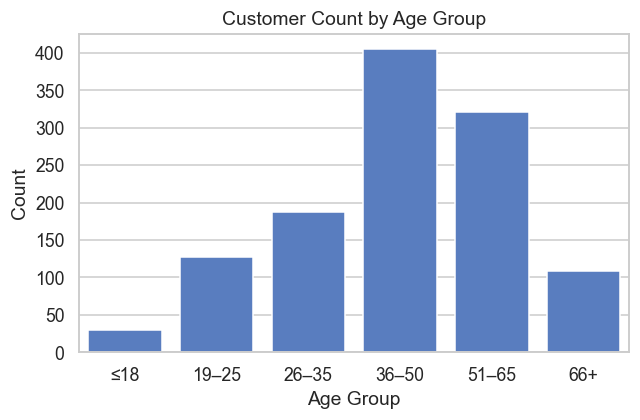

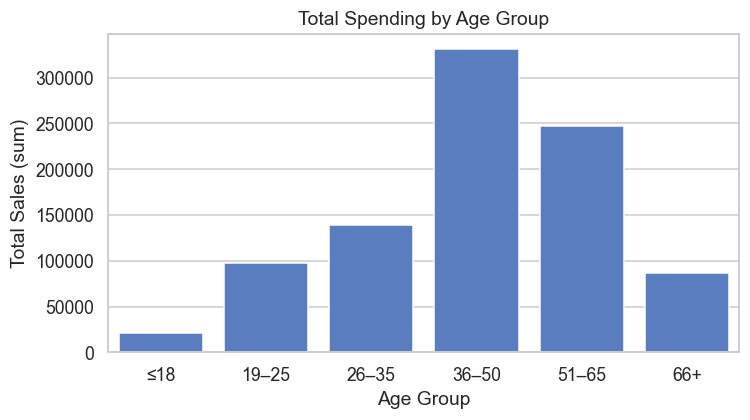

In [10]:
# Reuse df from Part A
for c in ["age","total_spent","avg_spent","num_transactions","max_transaction","min_transaction","engagement_score"]:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

# Age binning
if "age" in df.columns:
    df.loc[df["age"] < 0, "age"] = np.nan
    age_bins = [0, 18, 25, 35, 50, 65, np.inf]
    age_labels = ["≤18","19–25","26–35","36–50","51–65","66+"]
    df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

    fig = plt.figure(figsize=(6,4))
    ax = sns.countplot(x="age_group", data=df, order=age_labels)
    ax.set_title("Customer Count by Age Group"); ax.set_xlabel("Age Group"); ax.set_ylabel("Count")
    plt.tight_layout(); fig.savefig(OUT_DIR / "bar_age_groups.png"); plt.show()

    if "total_spent" in df.columns:
        fig = plt.figure(figsize=(7,4))
        sns.barplot(x="age_group", y="total_spent", data=df, estimator=sum, errorbar=None, order=age_labels)
        plt.title("Total Spending by Age Group"); plt.xlabel("Age Group"); plt.ylabel("Total Sales (sum)")
        plt.tight_layout(); fig.savefig(OUT_DIR / "bar_total_spent_by_age_group.png"); plt.show()


In [11]:
# IQR outlier flagging
def iqr_flags(series):
    q1 = series.quantile(0.25); q3 = series.quantile(0.75); iqr = q3 - q1
    lower = q1 - 1.5*iqr; upper = q3 + 1.5*iqr
    return (series < lower) | (series > upper), lower, upper

numeric_df = df.select_dtypes(include=["number"]).copy()
outlier_flags = pd.DataFrame(index=df.index); summary_rows = []

for col in numeric_df.columns:
    s = numeric_df[col].dropna()
    if s.empty:
        outlier_flags[col+"_outlier"] = False
        summary_rows.append({"column": col, "outliers": 0, "lower": np.nan, "upper": np.nan}); continue
    flags, lb, ub = iqr_flags(numeric_df[col])
    outlier_flags[col+"_outlier"] = flags.fillna(False)
    summary_rows.append({"column": col, "outliers": int(flags.sum()), "lower": float(lb), "upper": float(ub)})

outlier_summary = pd.DataFrame(summary_rows).sort_values("outliers", ascending=False)
df_with_flags = pd.concat([df, outlier_flags], axis=1)
outlier_summary.to_csv(OUT_DIR / "outlier_summary_iqr.csv", index=False)
df_with_flags.to_csv(OUT_DIR / "merged_with_outlier_flags.csv", index=False)
display(outlier_summary.head(10))
print("Saved flags ->", OUT_DIR / "outlier_summary_iqr.csv")


,column,outliers,lower,upper
3,num_transactions,41,-0.50000,3.50000
1,total_spent,36,-536.47250,1985.58750
0,age,13,-3.00000,93.00000
2,avg_spent,0,-215.07500,1203.34500
4,max_transaction,0,-269.10500,1476.01500
5,min_transaction,0,-484.58125,1267.88875
6,engagement_score,0,0.00000,0.00000


Saved flags -> eda_outputs/outlier_summary_iqr.csv


Original rows: 1,192 | After removing any IQR outlier: 1,122


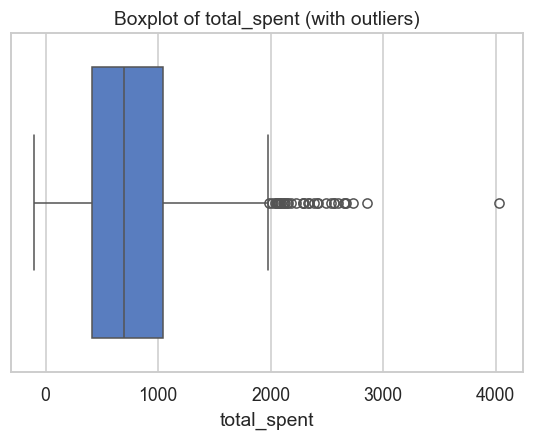

Saved: eda_outputs/box_total_spent_with_outliers.png


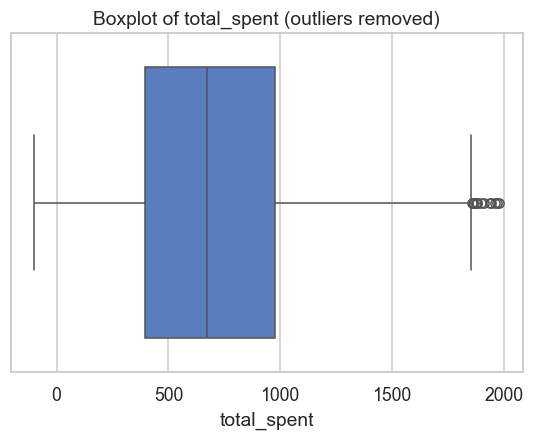

Saved: eda_outputs/box_total_spent_no_outliers.png


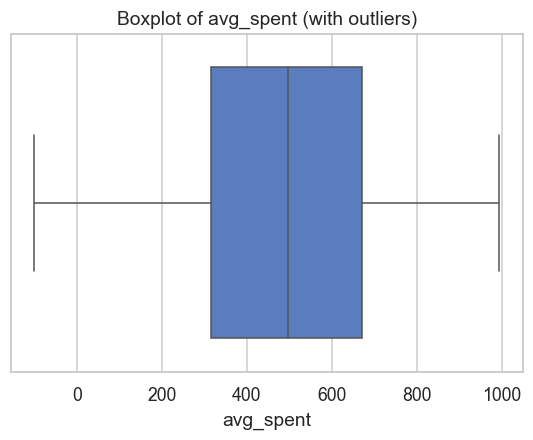

Saved: eda_outputs/box_avg_spent_with_outliers.png


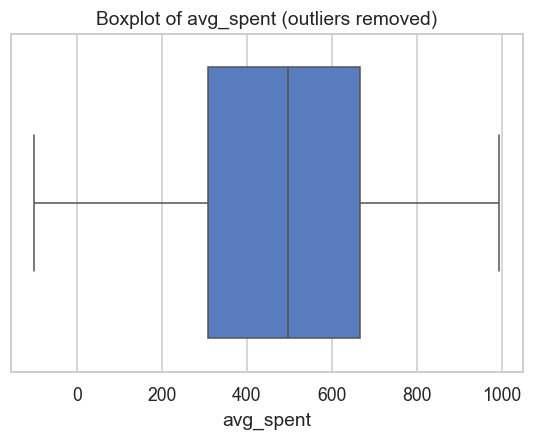

Saved: eda_outputs/box_avg_spent_no_outliers.png


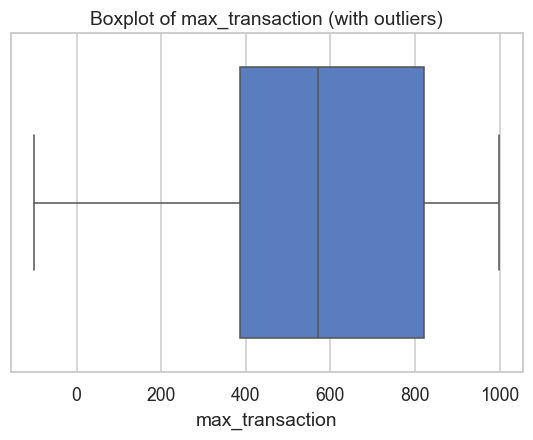

Saved: eda_outputs/box_max_transaction_with_outliers.png


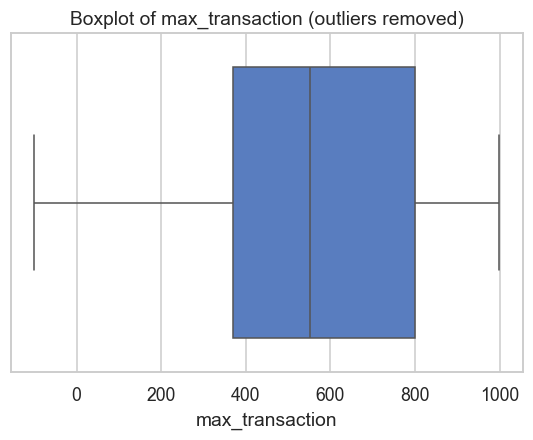

Saved: eda_outputs/box_max_transaction_no_outliers.png


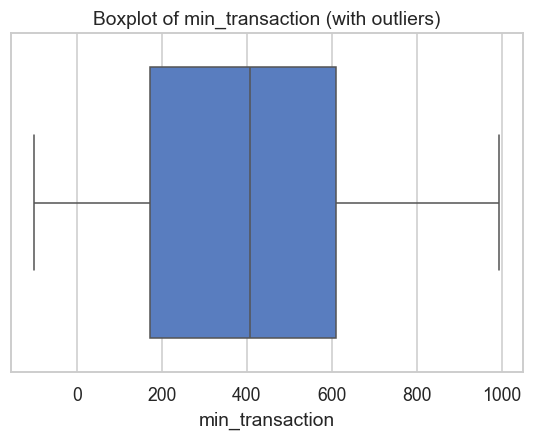

Saved: eda_outputs/box_min_transaction_with_outliers.png


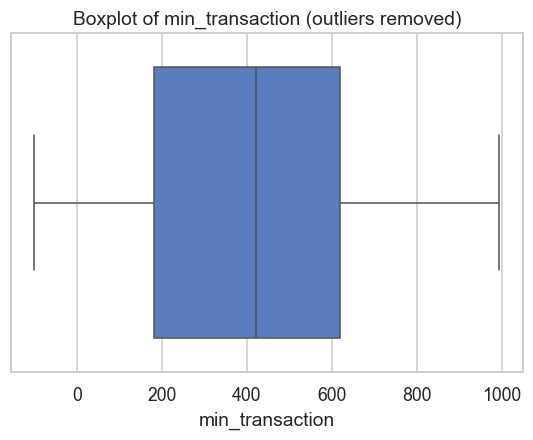

Saved: eda_outputs/box_min_transaction_no_outliers.png


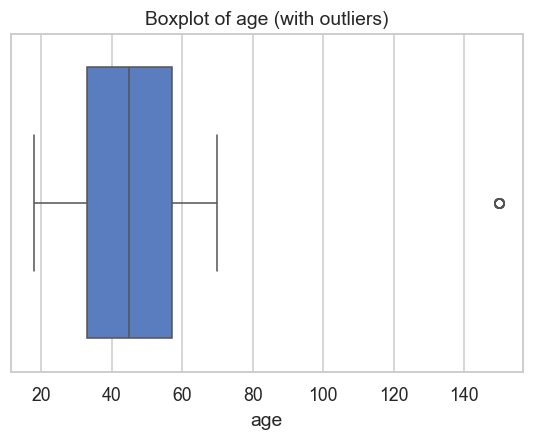

Saved: eda_outputs/box_age_with_outliers.png


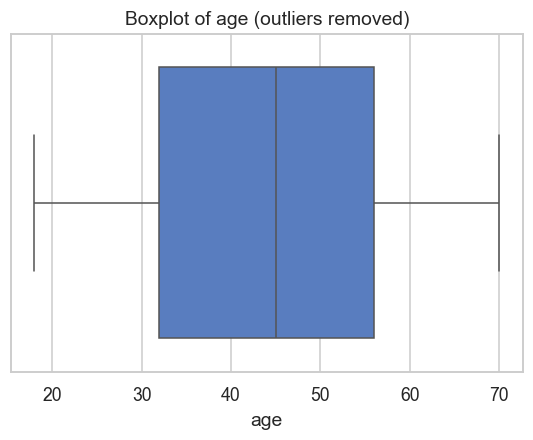

Saved: eda_outputs/box_age_no_outliers.png


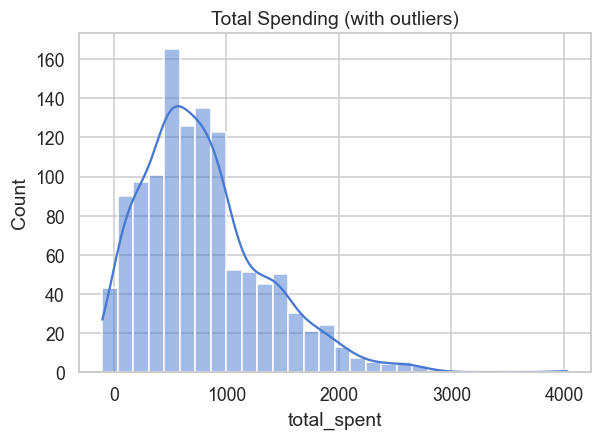

Saved: eda_outputs/hist_total_spent_with_outliers.png


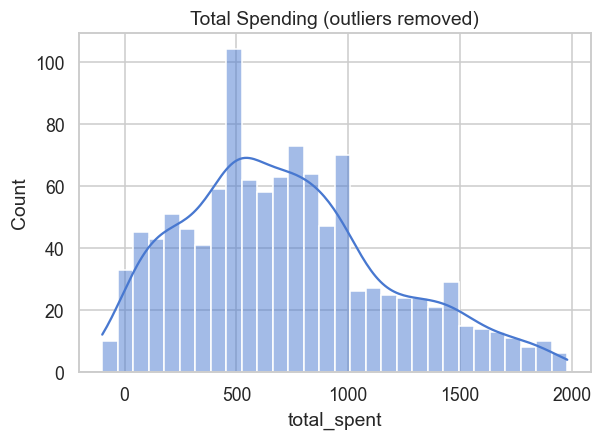

Saved: eda_outputs/hist_total_spent_no_outliers.png


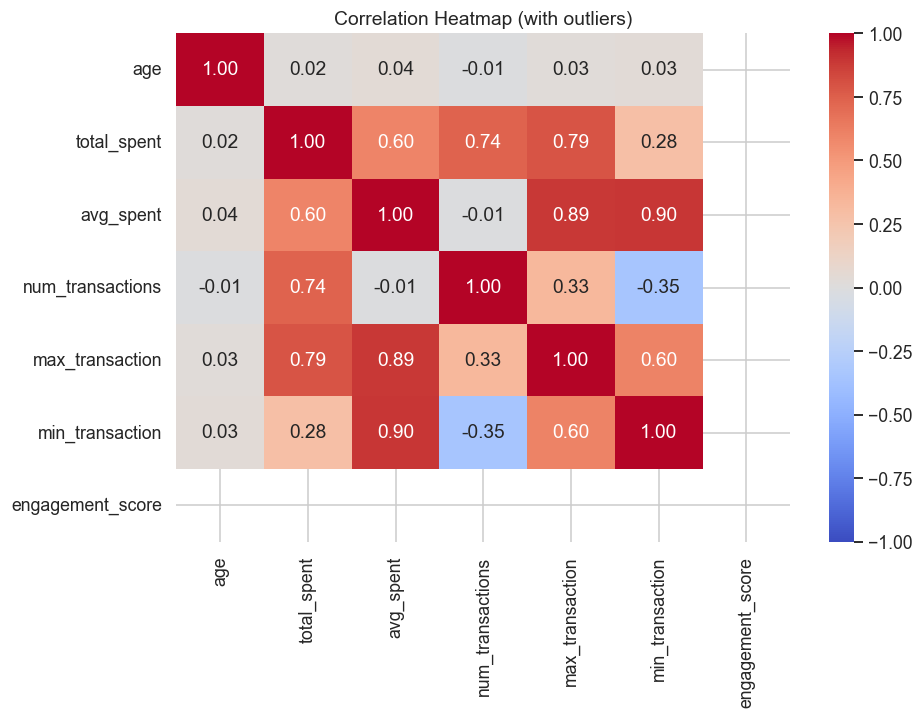

Saved: eda_outputs/heatmap_corr_with_outliers.png


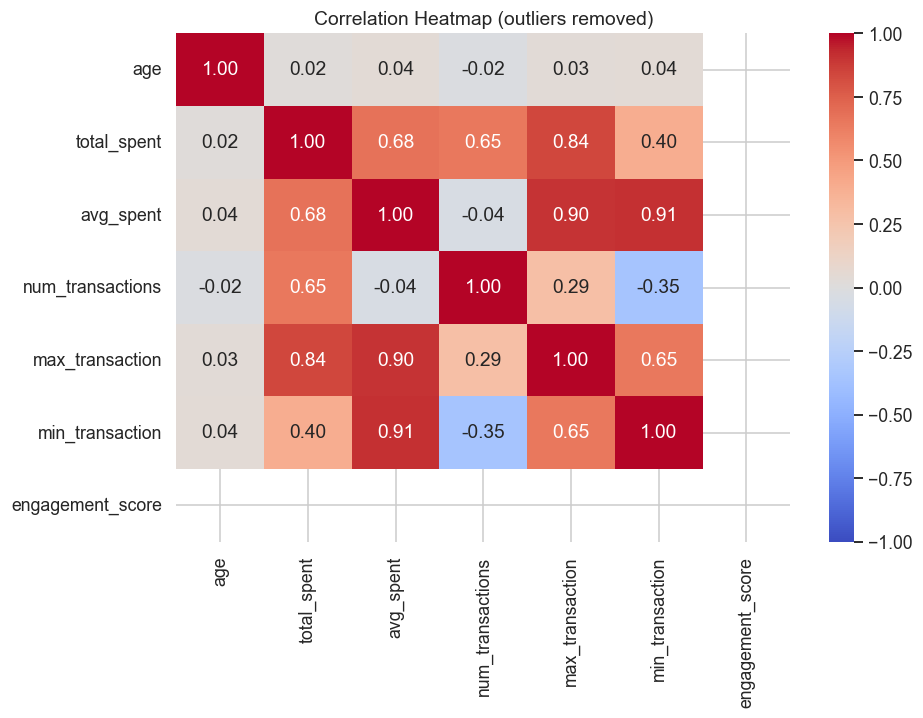

Saved: eda_outputs/heatmap_corr_no_outliers.png


In [12]:
# Optional removal + regenerated plots
DROP_OUTLIERS = True

if DROP_OUTLIERS:
    any_outlier = outlier_flags.any(axis=1)
    df_no_out = df_with_flags.loc[~any_outlier].copy()
    print(f"Original rows: {len(df_with_flags):,} | After removing any IQR outlier: {len(df_no_out):,}")
    df_no_out.to_csv("merged_cleaned_no_outliers.csv", index=False)
else:
    df_no_out = df_with_flags.copy()

def save_show(fig, name):
    p = OUT_DIR / f"{name}.png"
    fig.savefig(p, bbox_inches="tight"); plt.show()
    print(f"Saved: {p}")

for col in ["total_spent","avg_spent","max_transaction","min_transaction","age"]:
    if col in df.columns:
        fig = plt.figure(figsize=(6,4)); sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col} (with outliers)"); save_show(fig, f"box_{col}_with_outliers")
        fig = plt.figure(figsize=(6,4)); sns.boxplot(x=df_no_out[col].dropna())
        plt.title(f"Boxplot of {col} (outliers removed)"); save_show(fig, f"box_{col}_no_outliers")

if "total_spent" in df.columns:
    fig = plt.figure(figsize=(6,4)); sns.histplot(df["total_spent"].dropna(), bins=30, kde=True)
    plt.title("Total Spending (with outliers)"); save_show(fig, "hist_total_spent_with_outliers")
    fig = plt.figure(figsize=(6,4)); sns.histplot(df_no_out["total_spent"].dropna(), bins=30, kde=True)
    plt.title("Total Spending (outliers removed)"); save_show(fig, "hist_total_spent_no_outliers")

def corr_heatmap(d, title, fname):
    num = d.select_dtypes(include=["number"])
    if not num.empty:
        fig = plt.figure(figsize=(9,6))
        sns.heatmap(num.corr(numeric_only=True), annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
        plt.title(title); save_show(fig, fname)

corr_heatmap(df, "Correlation Heatmap (with outliers)", "heatmap_corr_with_outliers")
corr_heatmap(df_no_out, "Correlation Heatmap (outliers removed)", "heatmap_corr_no_outliers")


In [13]:
# Inferential checks on cleaned data
results = []

if "age_group" in df_no_out.columns and "total_spent" in df_no_out.columns:
    groups = [g["total_spent"].dropna().values for _, g in df_no_out[["total_spent","age_group"]].dropna().groupby("age_group", observed=True)]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) >= 2:
        F, p = stats.f_oneway(*groups); results.append(f"ANOVA total_spent ~ age_group: F={F:.4f}, p={p:.4g}")

if "gender" in df_no_out.columns and "total_spent" in df_no_out.columns:
    sub = df_no_out.dropna(subset=["gender","total_spent"]); cats = sub["gender"].value_counts().index.tolist()
    if len(cats) == 2:
        a = sub.loc[sub["gender"]==cats[0], "total_spent"]; b = sub.loc[sub["gender"]==cats[1], "total_spent"]
        t, p = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
        results.append(f"T-test total_spent by gender ({cats[0]} vs {cats[1]}): t={t:.4f}, p={p:.4g}")

for a,b in [("num_transactions","total_spent"), ("avg_spent","total_spent"), ("age","total_spent")]:
    if a in df_no_out.columns and b in df_no_out.columns:
        x = pd.to_numeric(df_no_out[a], errors="coerce"); y = pd.to_numeric(df_no_out[b], errors="coerce")
        ok = x.notna() & y.notna()
        if ok.sum() > 2:
            r,p = stats.pearsonr(x[ok], y[ok]); rs,ps = stats.spearmanr(x[ok], y[ok])
            results += [f"Pearson {a} vs {b}: r={r:.3f}, p={p:.4g}", f"Spearman {a} vs {b}: ρ={rs:.3f}, p={ps:.4g}"]

def chi2_pair(d, c1, c2):
    if c1 in d.columns and c2 in d.columns:
        tab = pd.crosstab(d[c1], d[c2])
        if tab.shape[0] > 1 and tab.shape[1] > 1:
            chi2, p, dof, exp = stats.chi2_contingency(tab)
            return f"Chi² {c1} vs {c2}: chi2={chi2:.3f}, p={p:.4g}"
for c1, c2 in [("gender","incomelevel"), ("gender","location")]:
    res = chi2_pair(df_no_out, c1, c2)
    if res: results.append(res)

with open(OUT_DIR / "inferential_tests_after_outlier_removal.txt", "w") as f:
    f.write("\n".join(results))
print("\n".join(results) if results else "No inferential results produced (check column availability).")
print("Saved:", OUT_DIR / "inferential_tests_after_outlier_removal.txt")


ANOVA total_spent ~ age_group: F=0.7318, p=0.5996
T-test total_spent by gender (Female vs Male): t=-0.6700, p=0.503
Pearson num_transactions vs total_spent: r=0.651, p=2.735e-136
Spearman num_transactions vs total_spent: ρ=0.624, p=5.101e-122
Pearson avg_spent vs total_spent: r=0.679, p=8.825e-153
Spearman avg_spent vs total_spent: ρ=0.735, p=5.537e-191
Pearson age vs total_spent: r=0.023, p=0.4424
Spearman age vs total_spent: ρ=0.015, p=0.6243
Chi² gender vs incomelevel: chi2=1.332, p=0.5138
Chi² gender vs location: chi2=1076.590, p=0.3627
Saved: eda_outputs/inferential_tests_after_outlier_removal.txt


### End of notebook

All figures/tables are saved into `eda_outputs/`. You can export to PDF via VS Code: `File → Export As → PDF`.


## Statistical Notes (Displayed Above Plots)

This section prints concise statistical results, followed by the corresponding chart.


ANOVA for total_spent by gender:
F-statistic: 0.0173, p-value: 0.8954
Result: No significant differences between groups.


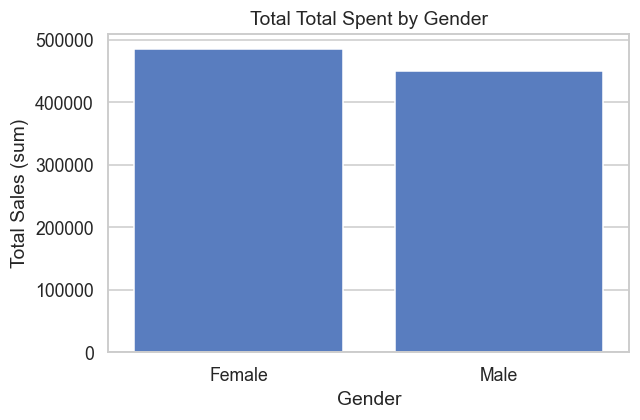

In [14]:
# ANOVA — total_spent by gender (adjust factor/target if needed)
factor = "gender"
target = "total_spent"

if factor in df.columns and target in df.columns:
    groups = [g[target].dropna().values for _, g in df[[target, factor]].dropna().groupby(factor)]
    valid = [g for g in groups if len(g) > 1]
    if len(valid) >= 2:
        F, p = stats.f_oneway(*valid)
        print(f"ANOVA for {target} by {factor}:")
        print(f"F-statistic: {F:.4f}, p-value: {p:.4g}")
        print("Result:", "Significant differences between groups." if p < 0.05 else "No significant differences between groups.")
        plt.figure(figsize=(6,4))
        sns.barplot(data=df, x=factor, y=target, estimator=sum, errorbar=None)
        plt.title(f"Total {target.replace('_',' ').title()} by {factor.title()}")
        plt.xlabel(factor.title()); plt.ylabel("Total Sales (sum)")
        plt.tight_layout(); plt.show()



ANOVA for total_spent by age_group:
F–statistic: 0.7946, p–value: 0.5535
Result: No significant differences between groups.


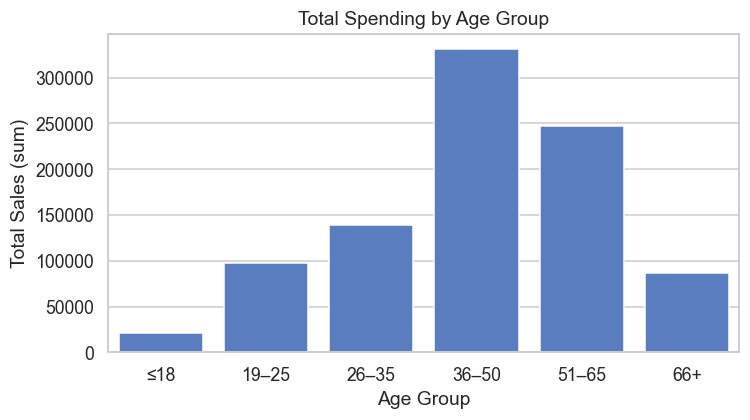

In [15]:
# ---------- ANOVA: total_spent by age_group ----------
if "age_group" in df.columns and "total_spent" in df.columns:
    # ensure age_group is categorical (avoid deprecated is_categorical_dtype)
    if not isinstance(df["age_group"].dtype, pd.CategoricalDtype):
        df["age_group"] = df["age_group"].astype("category")

    groups = [
        g["total_spent"].dropna().values
        for _, g in df[["total_spent", "age_group"]]
            .dropna()
            .groupby("age_group", observed=True)
    ]
    valid = [g for g in groups if len(g) > 1]
    if len(valid) >= 2:
        F, p = stats.f_oneway(*valid)
        print("\nANOVA for total_spent by age_group:")
        print(f"F–statistic: {F:.4f}, p–value: {p:.4g}")
        print("Result:",
              "Significant differences between groups." if p < 0.05
              else "No significant differences between groups.")
        plt.figure(figsize=(7,4))
        order = [c for c in df["age_group"].cat.categories if c in df["age_group"].unique()]
        sns.barplot(data=df, x="age_group", y="total_spent",
                    estimator=sum, errorbar=None, order=order)
        plt.title("Total Spending by Age Group")
        plt.xlabel("Age Group"); plt.ylabel("Total Sales (sum)")
        plt.tight_layout(); plt.show()


Correlation Heatmap (Numeric Features): values are Pearson r.


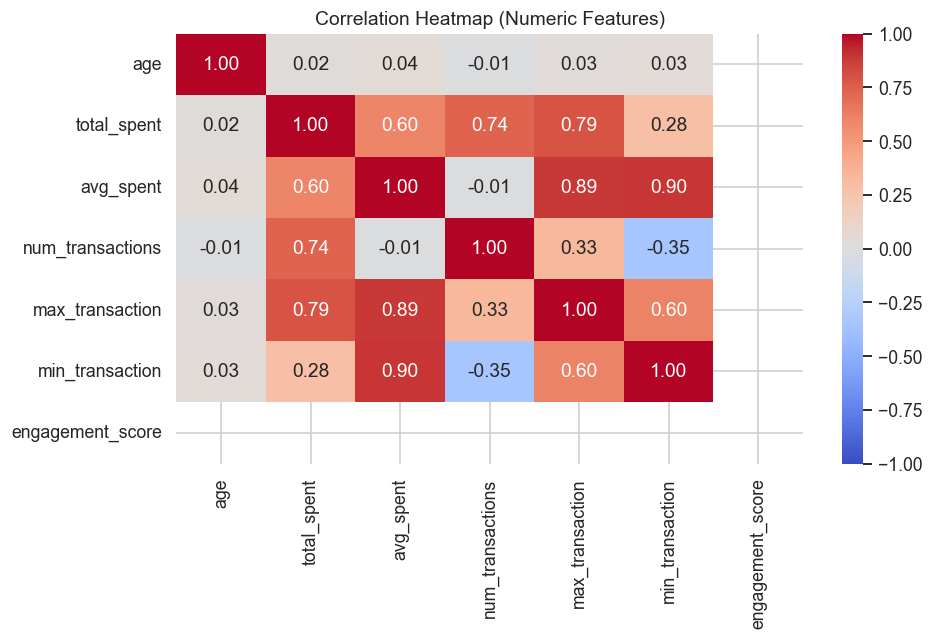

In [16]:
# Correlation heatmap — with a brief header above plot
num_df = df.select_dtypes(include=["number"]).copy()
if not num_df.empty:
    print("Correlation Heatmap (Numeric Features): values are Pearson r.")
    plt.figure(figsize=(9,6))
    sns.heatmap(num_df.corr(numeric_only=True), annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout(); plt.show()


In [17]:
# Pairwise Pearson correlation significance report (text only)
def pearson_significance_text(dframe):
    num = dframe.select_dtypes(include=["number"]).dropna(axis=1, how="all")
    cols = num.columns.tolist()
    print("Pearson Correlation Significance Test:")
    for a in cols:
        for b in cols:
            if a == b: 
                continue
            ab = num[[a,b]].dropna()
            if len(ab) > 2:
                r, p = stats.pearsonr(ab[a], ab[b])
                print(f"{a} vs {b} → r = {r:+.3f}, p = {p:.4f}")

pearson_significance_text(df)
# To run on outlier-removed data (if created earlier in the notebook), uncomment:
# pearson_significance_text(df_no_out)


Pearson Correlation Significance Test:
age vs total_spent → r = +0.019, p = 0.5095
age vs avg_spent → r = +0.039, p = 0.1799
age vs num_transactions → r = -0.011, p = 0.6961
age vs max_transaction → r = +0.031, p = 0.2882
age vs min_transaction → r = +0.035, p = 0.2357
age vs engagement_score → r = +nan, p = nan
total_spent vs age → r = +0.019, p = 0.5095
total_spent vs avg_spent → r = +0.599, p = 0.0000
total_spent vs num_transactions → r = +0.741, p = 0.0000
total_spent vs max_transaction → r = +0.791, p = 0.0000
total_spent vs min_transaction → r = +0.284, p = 0.0000
total_spent vs engagement_score → r = +nan, p = nan
avg_spent vs age → r = +0.039, p = 0.1799
avg_spent vs total_spent → r = +0.599, p = 0.0000
avg_spent vs num_transactions → r = -0.014, p = 0.6233
avg_spent vs max_transaction → r = +0.890, p = 0.0000
avg_spent vs min_transaction → r = +0.896, p = 0.0000
avg_spent vs engagement_score → r = +nan, p = nan
num_transactions vs age → r = -0.011, p = 0.6961
num_transactions 

Pearson avg_spent vs total_spent: r = +0.599, p = 5.352e-117


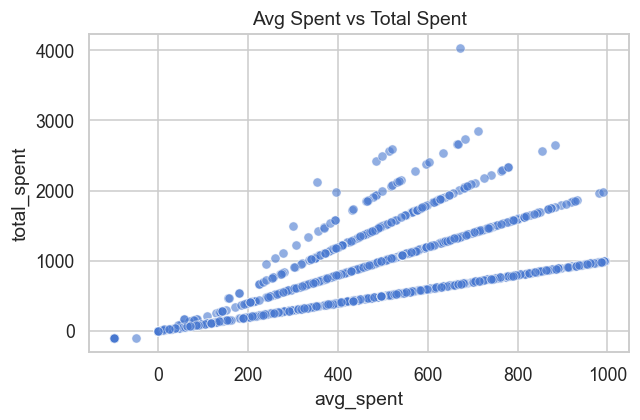

In [18]:
# Scatter example — print Pearson note then plot
x, y = "avg_spent", "total_spent"
if x in df.columns and y in df.columns:
    ab = df[[x,y]].dropna()
    if len(ab) > 2:
        r, p = stats.pearsonr(ab[x], ab[y])
        print(f"Pearson {x} vs {y}: r = {r:+.3f}, p = {p:.4g}")
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=ab, x=x, y=y, alpha=0.6)
        plt.title(f"{x.replace('_',' ').title()} vs {y.replace('_',' ').title()}")
        plt.tight_layout(); plt.show()


## Time Series — ADF Stationarity Test and Trend


ADF Test for Sales Trend Stationarity:
ADF Statistic: -7.8583, p-value: 0.0000
Result: Reject H0 → Sales trend is stationary.


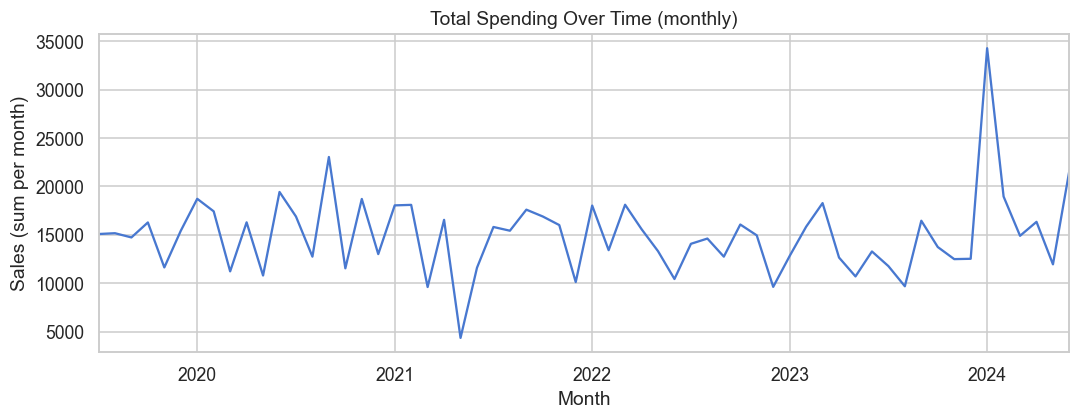

In [19]:
# ADF test on monthly total spending (prints results before the plot)
if all(c in df.columns for c in ["signupdate","total_spent"]):
    # parse dates defensively
    _tmp = df.copy()
    _tmp["signupdate"] = pd.to_datetime(_tmp["signupdate"], errors="coerce")
    ts = (_tmp.dropna(subset=["signupdate","total_spent"])
              .set_index("signupdate")["total_spent"]
              .resample("MS").sum())

    if ts.dropna().shape[0] >= 10:  # need enough observations for ADF
        adf_stat, pval, usedlag, nobs, crit, icbest = adfuller(ts.dropna(), autolag="AIC")
        print("ADF Test for Sales Trend Stationarity:")
        print(f"ADF Statistic: {adf_stat:.4f}, p-value: {pval:.4f}")
        print("Result:", "Reject H0 → Sales trend is stationary." if pval < 0.05 else "Fail to reject H0 → Sales trend is non-stationary.")
    else:
        print("ADF Test: insufficient monthly observations after resampling.")

    plt.figure(figsize=(10,4))
    ts.plot()
    plt.title("Total Spending Over Time (monthly)")
    plt.xlabel("Month"); plt.ylabel("Sales (sum per month)")
    plt.tight_layout(); plt.show()
else:
    print("Time series step skipped: columns 'signupdate' and/or 'total_spent' not found.")


## Scatter Plots — Key Relationships

The following relationship charts include statistical notes (Pearson and Spearman) printed immediately above each figure to support interpretation.


Average Spend vs Total Spend — Correlation Notes:
Pearson r = 0.599, p = 5.352e-117
Spearman ρ = 0.698, p = 1.122e-174


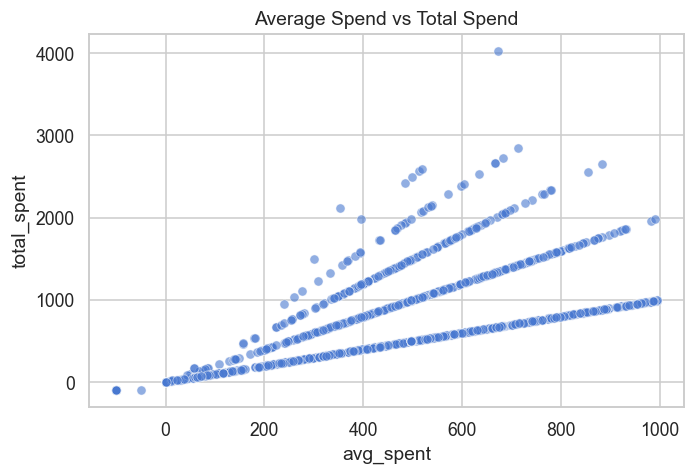

Age vs Total Spend — Correlation Notes:
Pearson r = 0.019, p = 0.5095
Spearman ρ = 0.023, p = 0.4297


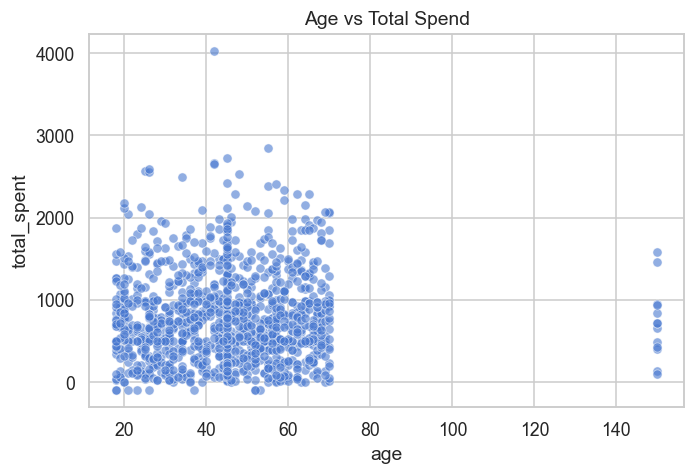

Engagement Score vs Total Spend — Not enough variation/non-null rows to compute correlation/plot.


In [20]:
pairs = [
    ("avg_spent", "total_spent", "scatter_avg_vs_total_spent.png", "Average Spend vs Total Spend"),
    ("age", "total_spent", "scatter_age_vs_total_spent.png", "Age vs Total Spend"),
    ("engagement_score", "total_spent", "scatter_engagement_vs_total_spent.png", "Engagement Score vs Total Spend"),
]

for xcol, ycol, fname, title in pairs:
    if xcol in df.columns and ycol in df.columns:
        sub = df[[xcol, ycol]].dropna().copy()
        if len(sub) >= 3 and sub[xcol].nunique() > 1 and sub[ycol].nunique() > 1:
            # Print correlation notes
            r, p = stats.pearsonr(sub[xcol], sub[ycol])
            rs, ps = stats.spearmanr(sub[xcol], sub[ycol])
            print(f"{title} — Correlation Notes:")
            print(f"Pearson r = {r:.3f}, p = {p:.4g}")
            print(f"Spearman ρ = {rs:.3f}, p = {ps:.4g}")
            # Plot
            plt.figure(figsize=(6.5,4.5))
            sns.scatterplot(data=sub, x=xcol, y=ycol, alpha=0.6)
            plt.title(title); plt.xlabel(xcol); plt.ylabel(ycol)
            plt.tight_layout(); plt.show()
            # Save
            OUT_DIR.mkdir(exist_ok=True)
            fig = plt.figure(figsize=(6.5,4.5))
            sns.scatterplot(data=sub, x=xcol, y=ycol, alpha=0.6)
            plt.title(title); plt.xlabel(xcol); plt.ylabel(ycol)
            plt.tight_layout(); fig.savefig(OUT_DIR / fname, bbox_inches="tight"); plt.close(fig)
        else:
            print(f"{title} — Not enough variation/non-null rows to compute correlation/plot.")
    else:
        print(f"{title} — Skipped: required columns not found.")


## Chi‑Square Tests — Categorical Associations

Automatically detects suitable categorical column pairs, prints chi‑square statistics, then shows simple bar charts for the top results.


In [21]:
from itertools import combinations

# Detect categorical columns (string/object/category) with a reasonable number of levels
cat_cols = [c for c in df.columns 
            if (df[c].dtype == "object" or str(df[c].dtype).startswith("category")) 
            and df[c].nunique(dropna=True) >= 2 and df[c].nunique(dropna=True) <= 20]

results = []
for c1, c2 in combinations(cat_cols, 2):
    tab = pd.crosstab(df[c1], df[c2])
    # require at least 2x2
    if tab.shape[0] > 1 and tab.shape[1] > 1:
        chi2, p, dof, exp = stats.chi2_contingency(tab)
        results.append((c1, c2, chi2, p, dof, tab.sum().sum()))

# Print summary, sorted by p-value (most significant first)
if results:
    results.sort(key=lambda x: x[3])  # by p
    print("Chi‑Square summary (top 10 by significance):")
    for (c1, c2, chi2, p, dof, n) in results[:10]:
        print(f"{c1} vs {c2} → Chi2: {chi2:.4f}, p-value: {p:.4g}, dof={dof}, N={n}")
else:
    print("No suitable categorical pairs found for chi‑square.")


Chi‑Square summary (top 10 by significance):
gender vs age_group → Chi2: 17.3305, p-value: 0.003914, dof=5, N=1179
gender vs incomelevel → Chi2: 2.2449, p-value: 0.3255, dof=2, N=1084
incomelevel vs age_group → Chi2: 7.8046, p-value: 0.6479, dof=10, N=1072



Chi‑Square Test for gender vs age_group:
Chi2: 17.3305, p-value: 0.003914
Result: Significant association.


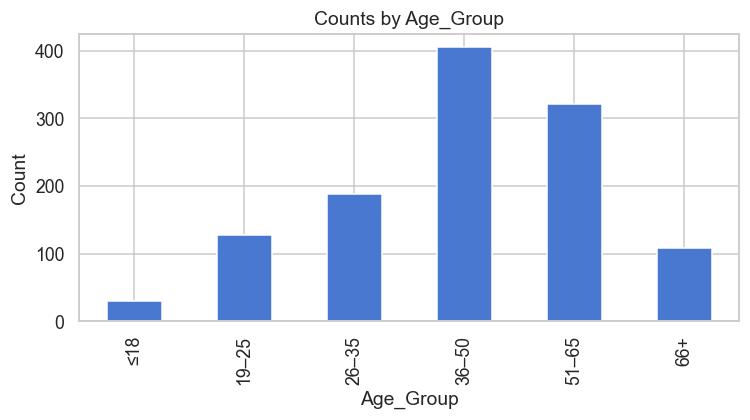


Chi‑Square Test for gender vs incomelevel:
Chi2: 2.2449, p-value: 0.3255
Result: No significant association.


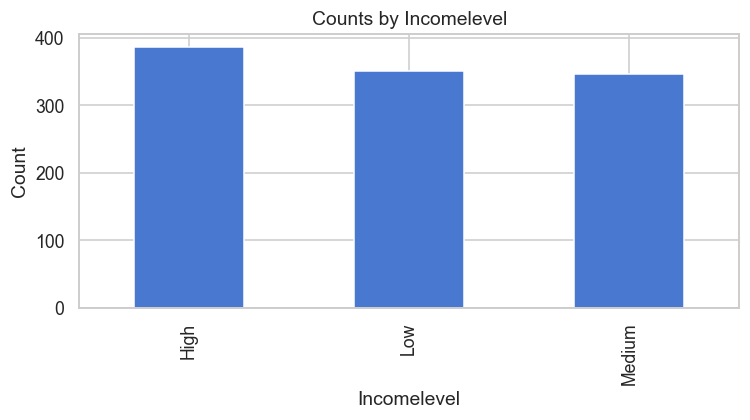


Chi‑Square Test for incomelevel vs age_group:
Chi2: 7.8046, p-value: 0.6479
Result: No significant association.


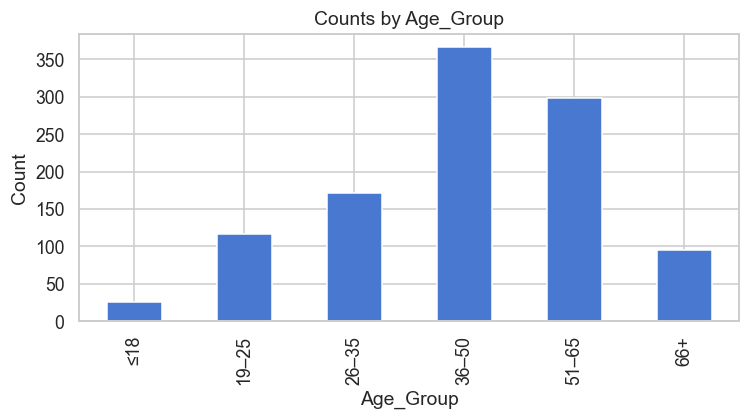

In [22]:
# Plot bar charts for up to the top 3 pairs (most significant p-values)
max_plots = 3
plotted = 0
for c1, c2, chi2, p, dof, n in results:
    if plotted >= max_plots:
        break
    print(f"\nChi‑Square Test for {c1} vs {c2}:")
    print(f"Chi2: {chi2:.4f}, p-value: {p:.4g}")
    print("Result:", "Significant association." if p < 0.05 else "No significant association.")

    # Simple bar chart: counts by c2
    plt.figure(figsize=(7,4))
    pd.crosstab(df[c1], df[c2]).sum(axis=0).plot(kind="bar")
    plt.ylabel("Count")
    plt.title(f"Counts by {c2.title()}")
    plt.xlabel(c2.title())
    plt.tight_layout(); plt.show()
    plotted += 1
